In [2]:
!pip install onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 130.5 MB/s eta 0:00:00


In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from onnxruntime.quantization import quantize_static, QuantFormat, QuantType

#load data

In [12]:
# Unzip dataset in Google Colab
import os
import zipfile
import shutil

zip_file_path = "/content/test.zip"
extract_dir = "/content/"

os.makedirs(extract_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            # Extract only the files we want, avoiding the extra directory structure and __MACOSX
            if not file_info.filename.startswith('__MACOSX/'):
                # Remove the leading 'cats-v-dogs/' from the filename if it exists
                arcname = file_info.filename
                if arcname.startswith('cats-v-non-cats/'):
                    arcname = arcname[len('cats-v-non-cats/'):]

                # Only extract if the filename is not empty after removing the prefix
                if arcname:
                    file_info.filename = arcname
                    zip_ref.extract(file_info, extract_dir)


    print(f"File extracted to: {extract_dir}")

    # Remove the __MACOSX folder if it exists
    macosx_folder = os.path.join("/content/", '__MACOSX')
    if os.path.exists(macosx_folder):
        shutil.rmtree(macosx_folder)
        print(f"Folder '{macosx_folder}' deleted successfully.")

except Exception as e:
    print(f"An error occurred during unzipping: {e}")

File extracted to: /content/


In [14]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = ImageFolder(root="./test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#load model

In [6]:
class CustomCNN(nn.Module):
    def __init__(self, reg_strength: float, dropout_conv: float, dropout_dense: float,
                 dense_units: int, filters_multiplier: float):
        super().__init__()
        f1 = max(8, int(32 * filters_multiplier))
        f2 = max(16, int(64 * filters_multiplier))
        f3 = max(32, int(128 * filters_multiplier))

        self.block1 = nn.Sequential(
            nn.Conv2d(3, f1, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f1),
            nn.Conv2d(f1, f1, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, f2, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f2),
            nn.Conv2d(f2, f2, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(f2, f3, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f3),
            nn.Conv2d(f3, f3, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(f3, dense_units), nn.ReLU(inplace=True),
            nn.BatchNorm1d(dense_units),
            nn.Dropout(dropout_dense),
            nn.Linear(dense_units, 1)
        )

    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.block3(x)
        x = self.gap(x)
        return self.head(x)

In [7]:
model_weights_path = "./final_best.pt"

ckpt = torch.load(model_weights_path, map_location="cpu")
config = ckpt["config"]
state = ckpt["state_dict"]

model = CustomCNN(
    config["reg_strength"],
    config["dropout_conv"],
    config["dropout_dense"],
    int(config["dense_units"]),
    float(config["filters_multiplier"])
).eval()

model.load_state_dict(state, strict=True)

<All keys matched successfully>

# evaluate

In [8]:
def evaluate_onnx_model(onnx_model_path, test_loader, model_pytorch):
    session = ort.InferenceSession(onnx_model_path)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    print(f"Evaluating ONNX model: {onnx_model_path}")

    correct_predictions = 0
    total_samples = 0

    print(f"ONNX model size: {os.path.getsize(onnx_model_path) / (1024 * 1024):.2f} MB")

    class_names = {1: 'non-cat', 0: 'cat'}

    for i, (inputs, labels) in enumerate(test_loader):
        inputs_np = inputs.cpu().numpy()

        outputs_np = session.run([output_name], {input_name: inputs_np})[0]

        probabilities = 1 / (1 + np.exp(-outputs_np)) # Sigmoid function
        predicted_classes = (probabilities > 0.5).squeeze()

        total_samples += labels.size(0)
        correct_predictions += (predicted_classes == labels.cpu().numpy()).sum().item()

    accuracy = correct_predictions / total_samples
    return accuracy

# onnx

In [9]:
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        prune.ln_structured(module, name='weight', amount=0.01, n=1, dim=0)
        print(f"Applied structured pruning to {name}")

for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        if prune.is_pruned(module):
            prune.remove(module, 'weight')
            print(f"Made pruning permanent for {name}")

print("Structured pruning applied and made permanent to convolutional and linear layers.")

Applied structured pruning to block1.0
Applied structured pruning to block1.3
Applied structured pruning to block2.0
Applied structured pruning to block2.3
Applied structured pruning to block3.0
Applied structured pruning to block3.3
Applied structured pruning to head.1
Applied structured pruning to head.5
Made pruning permanent for block1.0
Made pruning permanent for block1.3
Made pruning permanent for block2.0
Made pruning permanent for block2.3
Made pruning permanent for block3.0
Made pruning permanent for block3.3
Made pruning permanent for head.1
Made pruning permanent for head.5
Structured pruning applied and made permanent to convolutional and linear layers.


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for inputs, _ in test_loader:
    first_batch_inputs = inputs.to(device)
    break

output_onnx_path = "pruned_final_best.onnx"

torch.onnx.export(
    model, first_batch_inputs, output_onnx_path, verbose=False, input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"Pruned model exported to ONNX format at: {output_onnx_path}")

/tmp/ipython-input-73925561.py:10: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Pruned model exported to ONNX format at: pruned_final_best.onnx


In [16]:
input_onnx_path = "pruned_final_best.onnx"
output_quantized_onnx_path = "pruned_final_best_static_quantized.onnx"

print(f"Original (pruned) ONNX model size: {os.path.getsize(input_onnx_path) / (1024 * 1024):.2f} MB")

class DataReader(ort.quantization.CalibrationDataReader):
    def __init__(self, dataloader, onnx_model_path):
        self.dataloader = dataloader
        session_temp = ort.InferenceSession(onnx_model_path)
        self.input_name = session_temp.get_inputs()[0].name

        self.enum_data_dicts = iter([{self.input_name: batch[0].numpy()} for batch in dataloader])

    def get_next(self):
        try:
            data = next(self.enum_data_dicts)
            return data
        except StopIteration:
            return None

calibration_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
calibration_reader = DataReader(calibration_dataloader, input_onnx_path)

print("Applying static quantization...")
quantize_static(
    input_onnx_path,
    output_quantized_onnx_path,
    calibration_data_reader=calibration_reader,
    quant_format=QuantFormat.QOperator,
    per_channel=False,
    weight_type=QuantType.QInt8,
    activation_type=QuantType.QInt8
)

print(f"Static Quantized ONNX model saved to: {output_quantized_onnx_path}")
print(f"Static Quantized ONNX model size: {os.path.getsize(output_quantized_onnx_path) / (1024 * 1024):.2f} MB")

try:
    quantized_model_static = onnx.load(output_quantized_onnx_path)
    onnx.checker.check_model(quantized_model_static)
    print("Static Quantized ONNX model loaded and checked successfully.")
except Exception as e:
    print(f"Error loading or checking static quantized ONNX model: {e}")

Original (pruned) ONNX model size: 4.88 MB


Applying static quantization...


Static Quantized ONNX model saved to: pruned_final_best_static_quantized.onnx
Static Quantized ONNX model size: 1.25 MB
Static Quantized ONNX model loaded and checked successfully.


In [17]:
def evaluate_pytorch_model(model_pytorch, test_loader):
    model_pytorch.eval() # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculations during evaluation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_pytorch(inputs)
            probabilities = torch.sigmoid(outputs) # Apply sigmoid for binary classification
            predicted_classes = (probabilities > 0.5).squeeze()

            total_samples += labels.size(0)
            correct_predictions += (predicted_classes == labels).sum().item()

    accuracy = correct_predictions / total_samples
    return accuracy

In [18]:
original_pytorch_accuracy = evaluate_pytorch_model(model, test_loader)
print(f"Original PyTorch Model Accuracy: {original_pytorch_accuracy:.4f}")

original_pytorch_model_size = os.path.getsize(model_weights_path) / (1024 * 1024)
print(f"Original PyTorch Model Size: {original_pytorch_model_size:.2f} MB")

Original PyTorch Model Accuracy: 0.9654
Original PyTorch Model Size: 4.89 MB


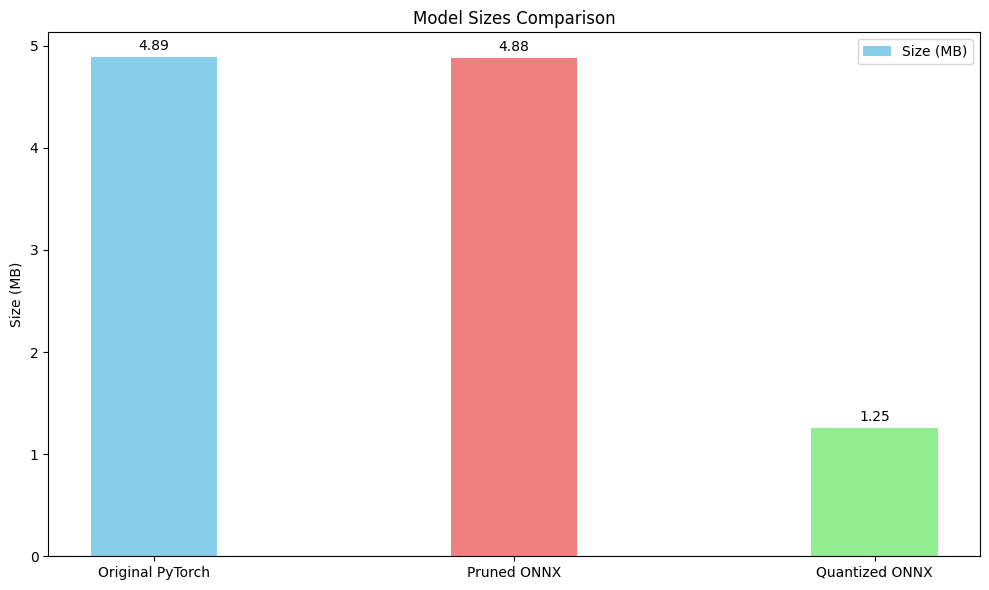

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Model sizes
model_names = ['Original PyTorch', 'Pruned ONNX', 'Quantized ONNX']
model_sizes = [
    original_pytorch_model_size,
    os.path.getsize(output_onnx_path) / (1024 * 1024),
    os.path.getsize(output_quantized_onnx_path) / (1024 * 1024)
]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, model_sizes, width, label='Size (MB)', color=['skyblue', 'lightcoral', 'lightgreen'])

ax.set_ylabel('Size (MB)')
ax.set_title('Model Sizes Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.tight_layout()
plt.show()

Evaluating ONNX model: pruned_final_best_static_quantized.onnx
ONNX model size: 1.25 MB
Static Quantized ONNX Model Accuracy: 0.9260
Evaluating ONNX model: pruned_final_best.onnx
ONNX model size: 4.88 MB


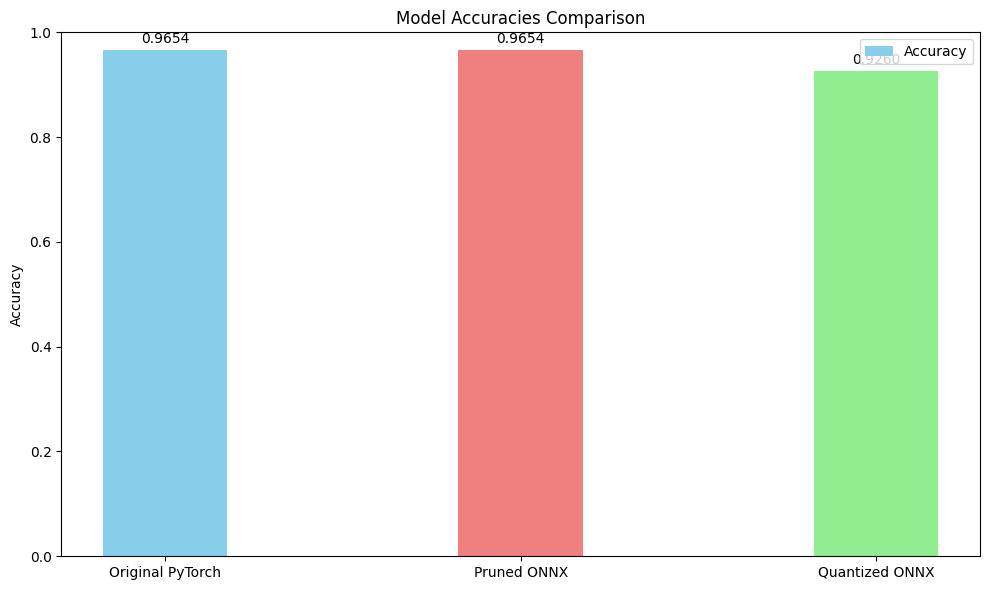

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define onnx_quantized_accuracy_static before use
onnx_quantized_accuracy_static = evaluate_onnx_model(output_quantized_onnx_path, test_loader, model)
print(f"Static Quantized ONNX Model Accuracy: {onnx_quantized_accuracy_static:.4f}")

# Model accuracies
model_accuracies = [
    original_pytorch_accuracy,
    evaluate_onnx_model(output_onnx_path, test_loader, model),
    onnx_quantized_accuracy_static
]

# Model names for plotting
model_names = ['Original PyTorch', 'Pruned ONNX', 'Quantized ONNX']

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects2 = ax.bar(x, model_accuracies, width, label='Accuracy', color=['skyblue', 'lightcoral', 'lightgreen'])

ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects2)

plt.tight_layout()
plt.show()

In [ ]:
onnx_quantized_accuracy_static = evaluate_onnx_model(output_quantized_onnx_path, test_loader, model)
print(f"Static Quantized ONNX Model Accuracy: {onnx_quantized_accuracy_static:.4f}")

Evaluating ONNX model: pruned_final_best_static_quantized.onnx
ONNX model size: 1.25 MB
Static Quantized ONNX Model Accuracy: 0.9260
